# Data plan:

1. Initial data exploration

2. EDA 

3. Initial model: compare models & optimise Hp

4. Final model deployment on test data. 

### Import packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.simplefilter(action = 'ignore', category = FutureWarning)
pd.set_option('display.max_columns', None)

## `Initial data exploration`

Outcome:
- `site_eui`

Variables fall into 3 broad categories:
- `building characteristics` :
    - 'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION'
    - 'State_Factor', 'building_class', 'facility_type'

- `climate`  - 
    - extreme temperature: `days_below`, `days_above`
    - 'cooling_degree_days', 'heating_degree_days' 
    
- `weather variables`:
    - temperature:`_min_temp`, `max_temp`, `_avg_temp`, `avg_temp`
    - others: 'precipitation_inches', 'snowfall_inches'
    - wind: 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed' 
    - fog: 'days_with_fog'
    - snow: 'snowdepth_inches'
    
- `others`: `id`

In [2]:
df = pd.read_csv("../input/widsdatathon2022/train.csv")
#df_test = pd.read_csv("../input/widsdatathon2022/test.csv")

print('No columns: ', len(df.columns))
# print()
# df.info()

No columns:  64


----------------------
### Types of features:

`Outcome` feature: 
- `site_eui` : Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

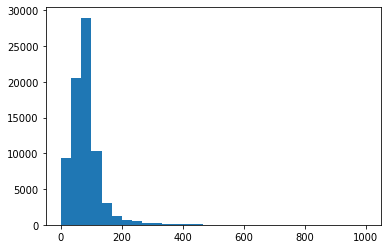

In [3]:
# print(df['site_eui'].describe())
plt.hist(df['site_eui'], bins = 30)
plt.show()

In [4]:
cols_dict = {}

for typ in ('object','float64', 'int64'):
    cols = df.select_dtypes(typ).columns
    cols_dict[typ] = cols.tolist()
    print ('{}: {}'.format(typ, len(cols)))
    print(cols.tolist())
    print()

object: 3
['State_Factor', 'building_class', 'facility_type']

float64: 24
['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'january_avg_temp', 'february_avg_temp', 'march_avg_temp', 'april_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_avg_temp', 'august_avg_temp', 'september_avg_temp', 'october_avg_temp', 'november_avg_temp', 'december_avg_temp', 'precipitation_inches', 'snowfall_inches', 'avg_temp', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog', 'site_eui']

int64: 37
['Year_Factor', 'january_min_temp', 'january_max_temp', 'february_min_temp', 'february_max_temp', 'march_min_temp', 'march_max_temp', 'april_min_temp', 'april_max_temp', 'may_min_temp', 'may_max_temp', 'june_min_temp', 'june_max_temp', 'july_min_temp', 'july_max_temp', 'august_min_temp', 'august_max_temp', 'september_min_temp', 'september_max_temp', 'october_min_temp', 'october_max_temp', 'november_min_temp', 'november_max_temp', 'december_min_temp', 'decem

### Categorical:

- `State_Factor`: 7 factors
- `building_class`: binary, residential vs commersial
- `facility_type`: 60, only 3 classes > 5%, top class 52%; reduce number

In [5]:
for col in cols_dict['object']:
    print('{}: {}'.format(col,df[col].unique().shape[0]))

State_Factor: 7
building_class: 2
facility_type: 60


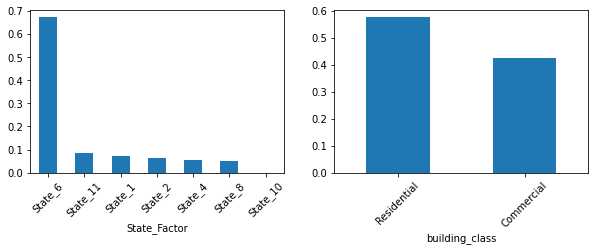

In [6]:
plt.figure(figsize = (10,3))
for pl, col in zip([1,2], cols_dict['object'][:2]):
    plt.subplot(1,2,pl)
    df[col].value_counts(normalize = True).plot(kind = 'bar')
    plt.xticks(rotation = 45)
    plt.xlabel(col)

# for col in cols_dict['object']:
#    print(col, ": ", df[col].value_counts().shape[0])
#    print(df[col].value_counts())
#    print()

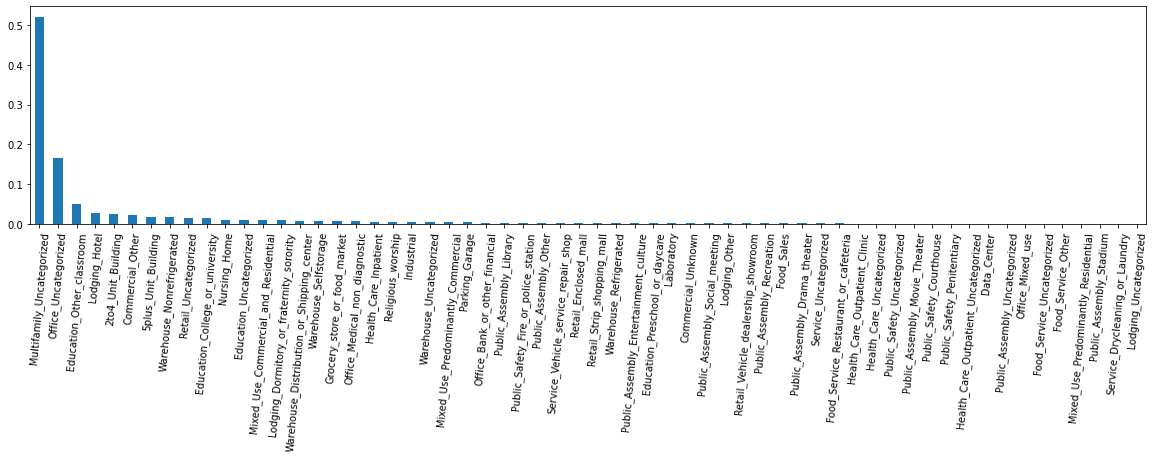

In [7]:
plt.figure(figsize = (20,4))
df['facility_type'].value_counts(normalize = True).plot(kind = 'bar')
plt.xticks(rotation = 85)
plt.show()

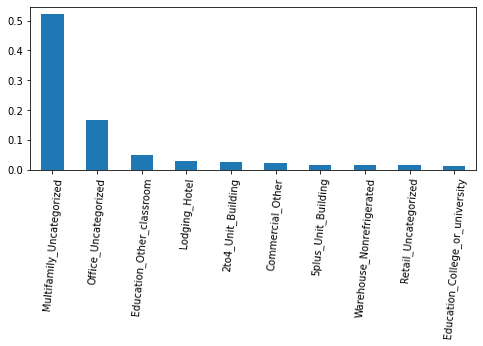

In [8]:
plt.figure(figsize = (8,3))
df['facility_type'].value_counts(normalize = True)[:10].plot(kind = 'bar')
plt.xticks(rotation = 85)
plt.show()

#### `Year related features`

- `Year_Factor` add to `cols_dict['object']`
- `year_built` conversion + some values = 0.

In [9]:
df['Year_Factor'].unique()
df['year_built'].describe(datetime_is_numeric = True)

count    73920.000000
mean      1952.306764
std         37.053619
min          0.000000
25%       1927.000000
50%       1951.000000
75%       1977.000000
max       2015.000000
Name: year_built, dtype: float64

In [10]:
# df_extra = df
# df_extra['years_since'] = 2022 - df['year_built']
# plt.scatter(df['years_since'], df['energy_star_rating'])

### `Continious Features`:

- ``: 

In [11]:
for col in cols_dict['float64'][:3]:
    print(col)
    print(df[col].describe()[['mean','50%','25%','75%']])
    print()

floor_area
mean    165983.865858
50%      91367.000000
25%      62379.000000
75%     166000.000000
Name: floor_area, dtype: float64

year_built
mean    1952.306764
50%     1951.000000
25%     1927.000000
75%     1977.000000
Name: year_built, dtype: float64

energy_star_rating
mean    61.048605
50%     67.000000
25%     40.000000
75%     85.000000
Name: energy_star_rating, dtype: float64



----------
## `Exploratory Data Analysis`:

### Examine `Temperature measures`:

#### Average measures:
- `_min_temp`, `_avg_temp`, `_max_temp` + 1 `avg_temp`
- 3 x 12 + 1

In [12]:
dict_temp = {}
dict_temp['tempetature'] = df.columns[[c.endswith('temp') for c in df.columns]].tolist()

temp_cols = df.columns[[c.endswith('temp') for c in df.columns]].tolist()
df.columns[[c.endswith('temp') for c in df.columns]] #.tolist()

Index(['january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'avg_temp'],
      dtype='object')

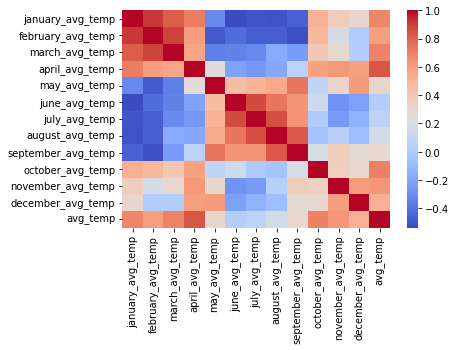

In [13]:
temp_corr = df[df.columns[[c.endswith('avg_temp') for c in df.columns]].tolist()].corr()
sns.heatmap(temp_corr, cmap="coolwarm")
plt.show()

In [14]:
temp_min = df[df.columns[[el.endswith('min_temp') for el in df.columns]]].describe().T
temp_min['month'] = temp_min.index
temp_min['month'] = [m.replace('_min_temp','') for m in temp_min.index]

temp_max = df[df.columns[[el.endswith('max_temp') for el in df.columns]]].describe().T
temp_max['month'] = temp_max.index
temp_max['month'] = [m.replace('_max_temp','') for m in temp_max.index]

temp_avg = df[df.columns[[el.endswith('_avg_temp') for el in df.columns]]].describe().T
temp_avg['month'] = temp_avg.index
temp_avg['month'] = [m.replace('_avg_temp','') for m in temp_avg.index]

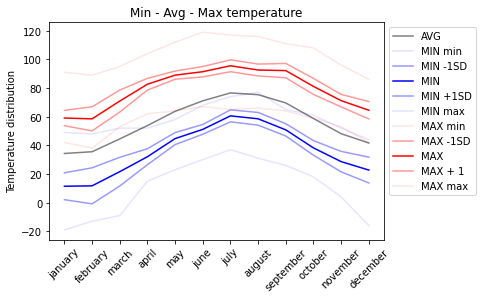

In [15]:
plt.plot(temp_avg['month'], temp_avg['mean'], label = 'AVG', color = 'grey')

plt.plot(temp_min['month'], temp_min['min'], label = 'MIN min', color = 'blue', alpha = 0.1)
plt.plot(temp_min['month'], (temp_min['mean'] - temp_min['std']), label = 'MIN -1SD', 
         color = 'blue', alpha = 0.4)
plt.plot(temp_min['month'], temp_min['mean'], label = 'MIN', color = 'blue')
plt.plot(temp_min['month'], (temp_min['mean'] + temp_min['std']), label = 'MIN +1SD', 
         color = 'blue', alpha = 0.4)
plt.plot(temp_min['month'], temp_min['max'], label = 'MIN max', color = 'blue', alpha = 0.1)

plt.plot(temp_max['month'], temp_max['min'], label = 'MAX min', color = 'red', alpha = 0.1)
plt.plot(temp_max['month'], (temp_max['mean'] - temp_max['std']), label = 'MAX -1SD', 
         color = 'red', alpha = 0.4)
plt.plot(temp_max['month'], temp_max['mean'], label = 'MAX', color = 'red')
plt.plot(temp_max['month'], (temp_max['mean'] + temp_max['std']), label = 'MAX + 1', 
         color = 'red', alpha = 0.4)
plt.plot(temp_max['month'], temp_max['max'], label = 'MAX max', color = 'red', alpha = 0.1)

plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Min - Avg - Max temperature')
plt.ylabel('Temperature distribution')
plt.show()

#### Extreme temperatures:

- `days_below_*` and `days_above_*`

In [16]:
below = df.columns[[c.startswith('days_below') for c in df.columns]]
above = df.columns[[c.startswith('days_above') for c in df.columns]]
extreme = df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]]

dict_temp['extreme'] = df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]].to_list()

df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]]

Index(['days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F',
       'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F'],
      dtype='object')

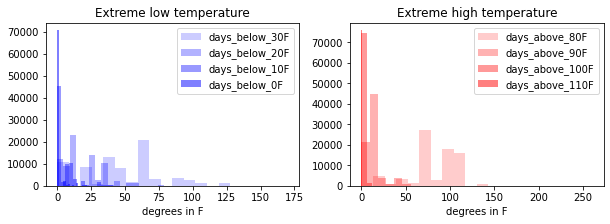

In [17]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
for alpha, b in zip([0.2,0.3,0.4,0.5], below):
    plt.hist(df[b], color = 'blue', alpha = alpha, bins = 20, label = b)
    plt.legend()
    plt.title('Extreme low temperature')
    plt.xlabel('degrees in F')
    
plt.subplot(1,2,2)
for alpha, a in zip([0.2,0.3,0.4,0.5], above):
    plt.hist(df[a], color = 'red', alpha = alpha, bins = 20, label = a)
    plt.legend()
    plt.title('Extreme high temperature')
    plt.xlabel('degrees in F')

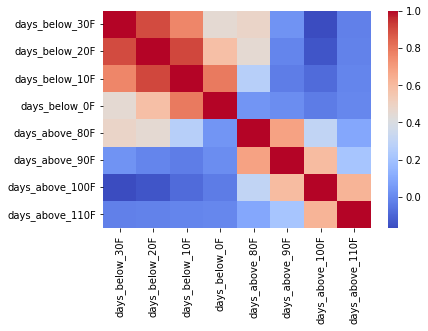

In [18]:
extr_corr = df[df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]].tolist()].corr()
sns.heatmap(extr_corr, cmap="coolwarm")
plt.show()

In [19]:
df.drop((dict_temp['tempetature'] + dict_temp['extreme']), axis = 1).head(n = 3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,1.0,NaN,1.0,12.0,24.693619,2


-----------------
### `Missing data`:

- `year_built` some data are 0, assign to 0. Calculate `years since built`?
- ``

<AxesSubplot:>

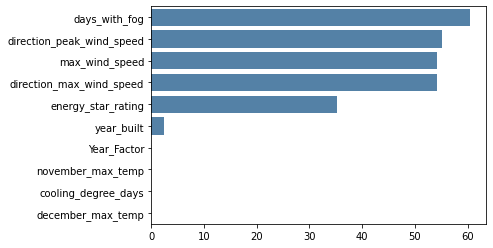

In [20]:
missing_data = np.round((df.isnull().sum() / df.shape[0]) * 100, 2).sort_values(ascending = False)[:10]

sns.barplot(missing_data.values, missing_data.index, color = 'steelblue')

In [21]:
df[df['year_built'] == 0]

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
353,1,State_1,Commercial,Lodging_Hotel,204392.0,0.0,61.0,59.1,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,NaN,NaN,NaN,NaN,82.627179,353
955,2,State_1,Commercial,Lodging_Hotel,204392.0,0.0,63.0,2.4,27,48.951613,69,33,51.655172,78,34,52.822581,74,37,58.850000,90,45,64.612903,92,49,67.900000,103,53,70.467742,99,52,71.806452,100,49,68.466667,97,43,63.983871,100,35,55.283333,79,28,47.919355,65,791,2439,19.27,0.0,0,60.247268,3,0,0,0,113,35,1,0,1.0,1.0,1.0,88.0,87.526794,955
2159,3,State_1,Commercial,Lodging_Hotel,204392.0,0.0,63.0,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,57.082192,33,2,0,0,72,10,0,0,NaN,NaN,NaN,NaN,75.362740,2159
3415,4,State_1,Commercial,Lodging_Hotel,204392.0,0.0,68.0,9.1,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,NaN,NaN,NaN,NaN,61.793699,3415
4535,5,State_1,Commercial,Lodging_Hotel,204392.0,0.0,76.0,9.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,1319,1823,7.95,0.0,0,63.398630,4,0,0,0,136,52,10,0,NaN,NaN,NaN,NaN,59.503653,4535
5571,6,State_1,Commercial,Lodging_Hotel,204392.0,0.0,78.0,45.7,37,52.693548,62,42,56.948276,75,47,57.725806,76,47,60.283333,86,51,61.064516,87,51,63.350000,87,53,62.919355,81,53,63.790323,76,52,64.800000,94,51,63.354839,84,44,58.283333,75,36,50.661290,63,142,2005,21.39,0.0,0,59.648907,0,0,0,0,16,2,0,0,NaN,NaN,NaN,NaN,60.833333,5571


-----------------
### `Impute missing data`:

- impute `enegery_star_rating` using year_built and other features?